# Exploratory Data Analysis

Comes from: https://www.kaggle.com/dude431/beginner-s-visualization-and-removing-uniformative

In [1]:
import numpy as np
import os
from tqdm import tqdm
import wave
from scipy.io import wavfile
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train = pd.read_csv("data/train_curated.csv")
train_noisy = pd.read_csv("data/train_noisy.csv")
test = pd.read_csv("data/sample_submission.csv")

In [3]:
print(train.shape)
print(train_noisy.shape)
print(test.shape)

(4970, 2)
(19815, 2)
(1120, 81)


## Class Distribution

We would like to understand how the classes/labels are distributed in both the curated and noisy training sets. Are there any problems with class balance that we should be aware of? We will start by looking at the labels individually below.

In [4]:
#TODO: Replace with Binarizer? It's much faster.
def breakLabelsApart(dataDf, structureDf):

    columns = structureDf.columns
    new_df = pd.DataFrame(data=None, columns=columns, index=dataDf.index)

    for index, row in dataDf.iterrows():
        fname = row['fname']
        allLabels = row['labels']
        splitLabels = allLabels.split(',')

        columnDict = {}
        for i in columns:
            columnDict[i] = 0

        columnDict['fname'] = fname
        for label in splitLabels:
            columnDict[label] = 1

        new_df = new_df.append(columnDict, ignore_index=True)
    
    return new_df

In [5]:
%time train_one_hot = breakLabelsApart(train, test)

CPU times: user 56.6 s, sys: 15.5 s, total: 1min 12s
Wall time: 1min 12s


In [6]:
%time train_noisy_one_hot = breakLabelsApart(train_noisy, test)

CPU times: user 9min 55s, sys: 4min 18s, total: 14min 14s
Wall time: 14min 14s


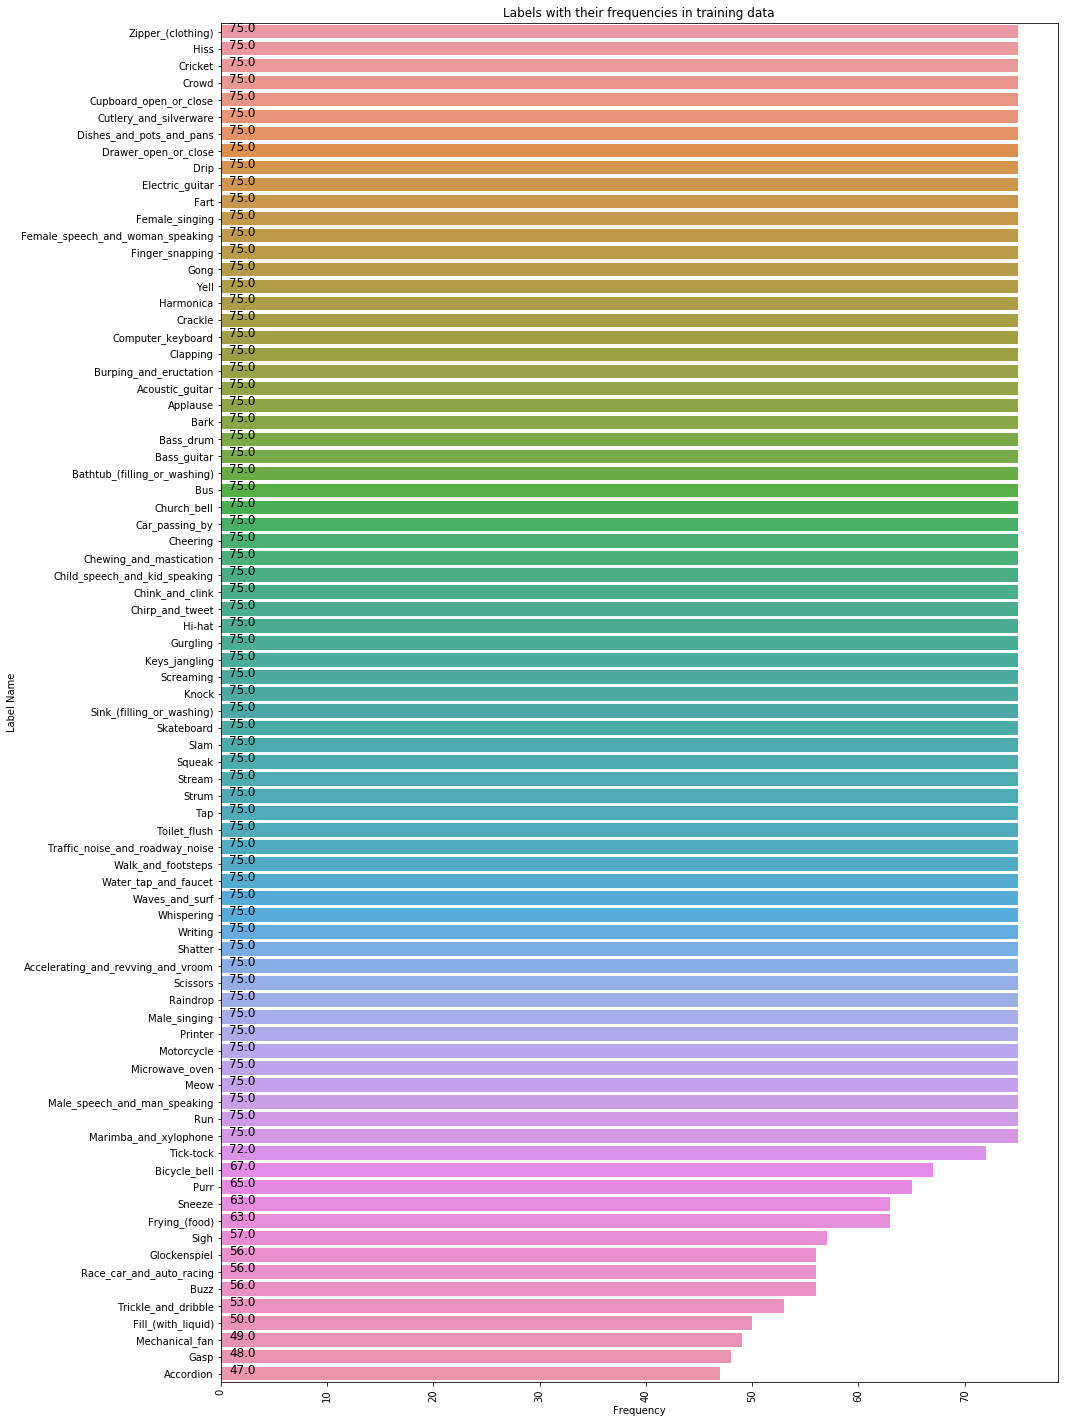

In [7]:
plt.figure(figsize=(15,25))
audio_type = train_one_hot.loc[:, 'Accelerating_and_revving_and_vroom':'Zipper_(clothing)'].sum(axis = 0).sort_values(ascending=False)
sns.barplot(audio_type.values, audio_type.index)
for i, v in enumerate(audio_type.values):
    plt.text(0.8,i,v,color='k',fontsize=12)
plt.xticks(rotation='vertical')
plt.xlabel('Frequency')
plt.ylabel('Label Name')
plt.title("Labels with their frequencies in training data")
plt.show()

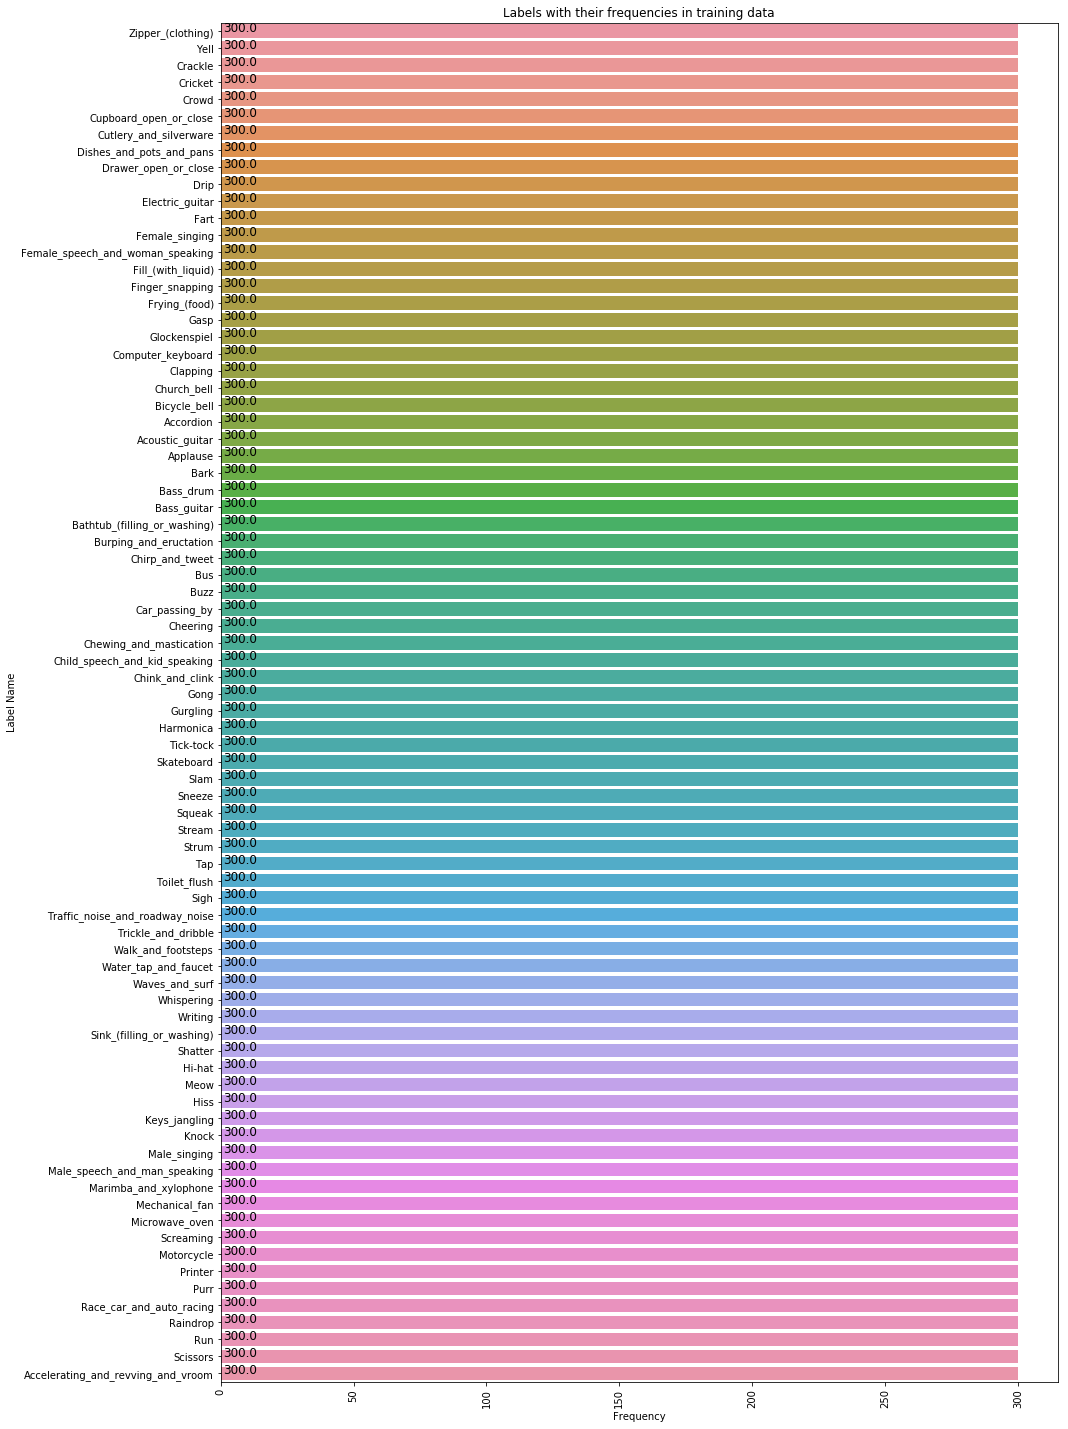

In [8]:
plt.figure(figsize=(15,25))
audio_type = train_noisy_one_hot.loc[:, 'Accelerating_and_revving_and_vroom':'Zipper_(clothing)'].sum(axis = 0).sort_values(ascending=False)
sns.barplot(audio_type.values, audio_type.index)
for i, v in enumerate(audio_type.values):
    plt.text(0.8,i,v,color='k',fontsize=12)
plt.xticks(rotation='vertical')
plt.xlabel('Frequency')
plt.ylabel('Label Name')
plt.title("Labels with their frequencies in training data")
plt.show()

Some audio samples contain multiple noise sources. We can look at the distribution for the combination of these sources as well.

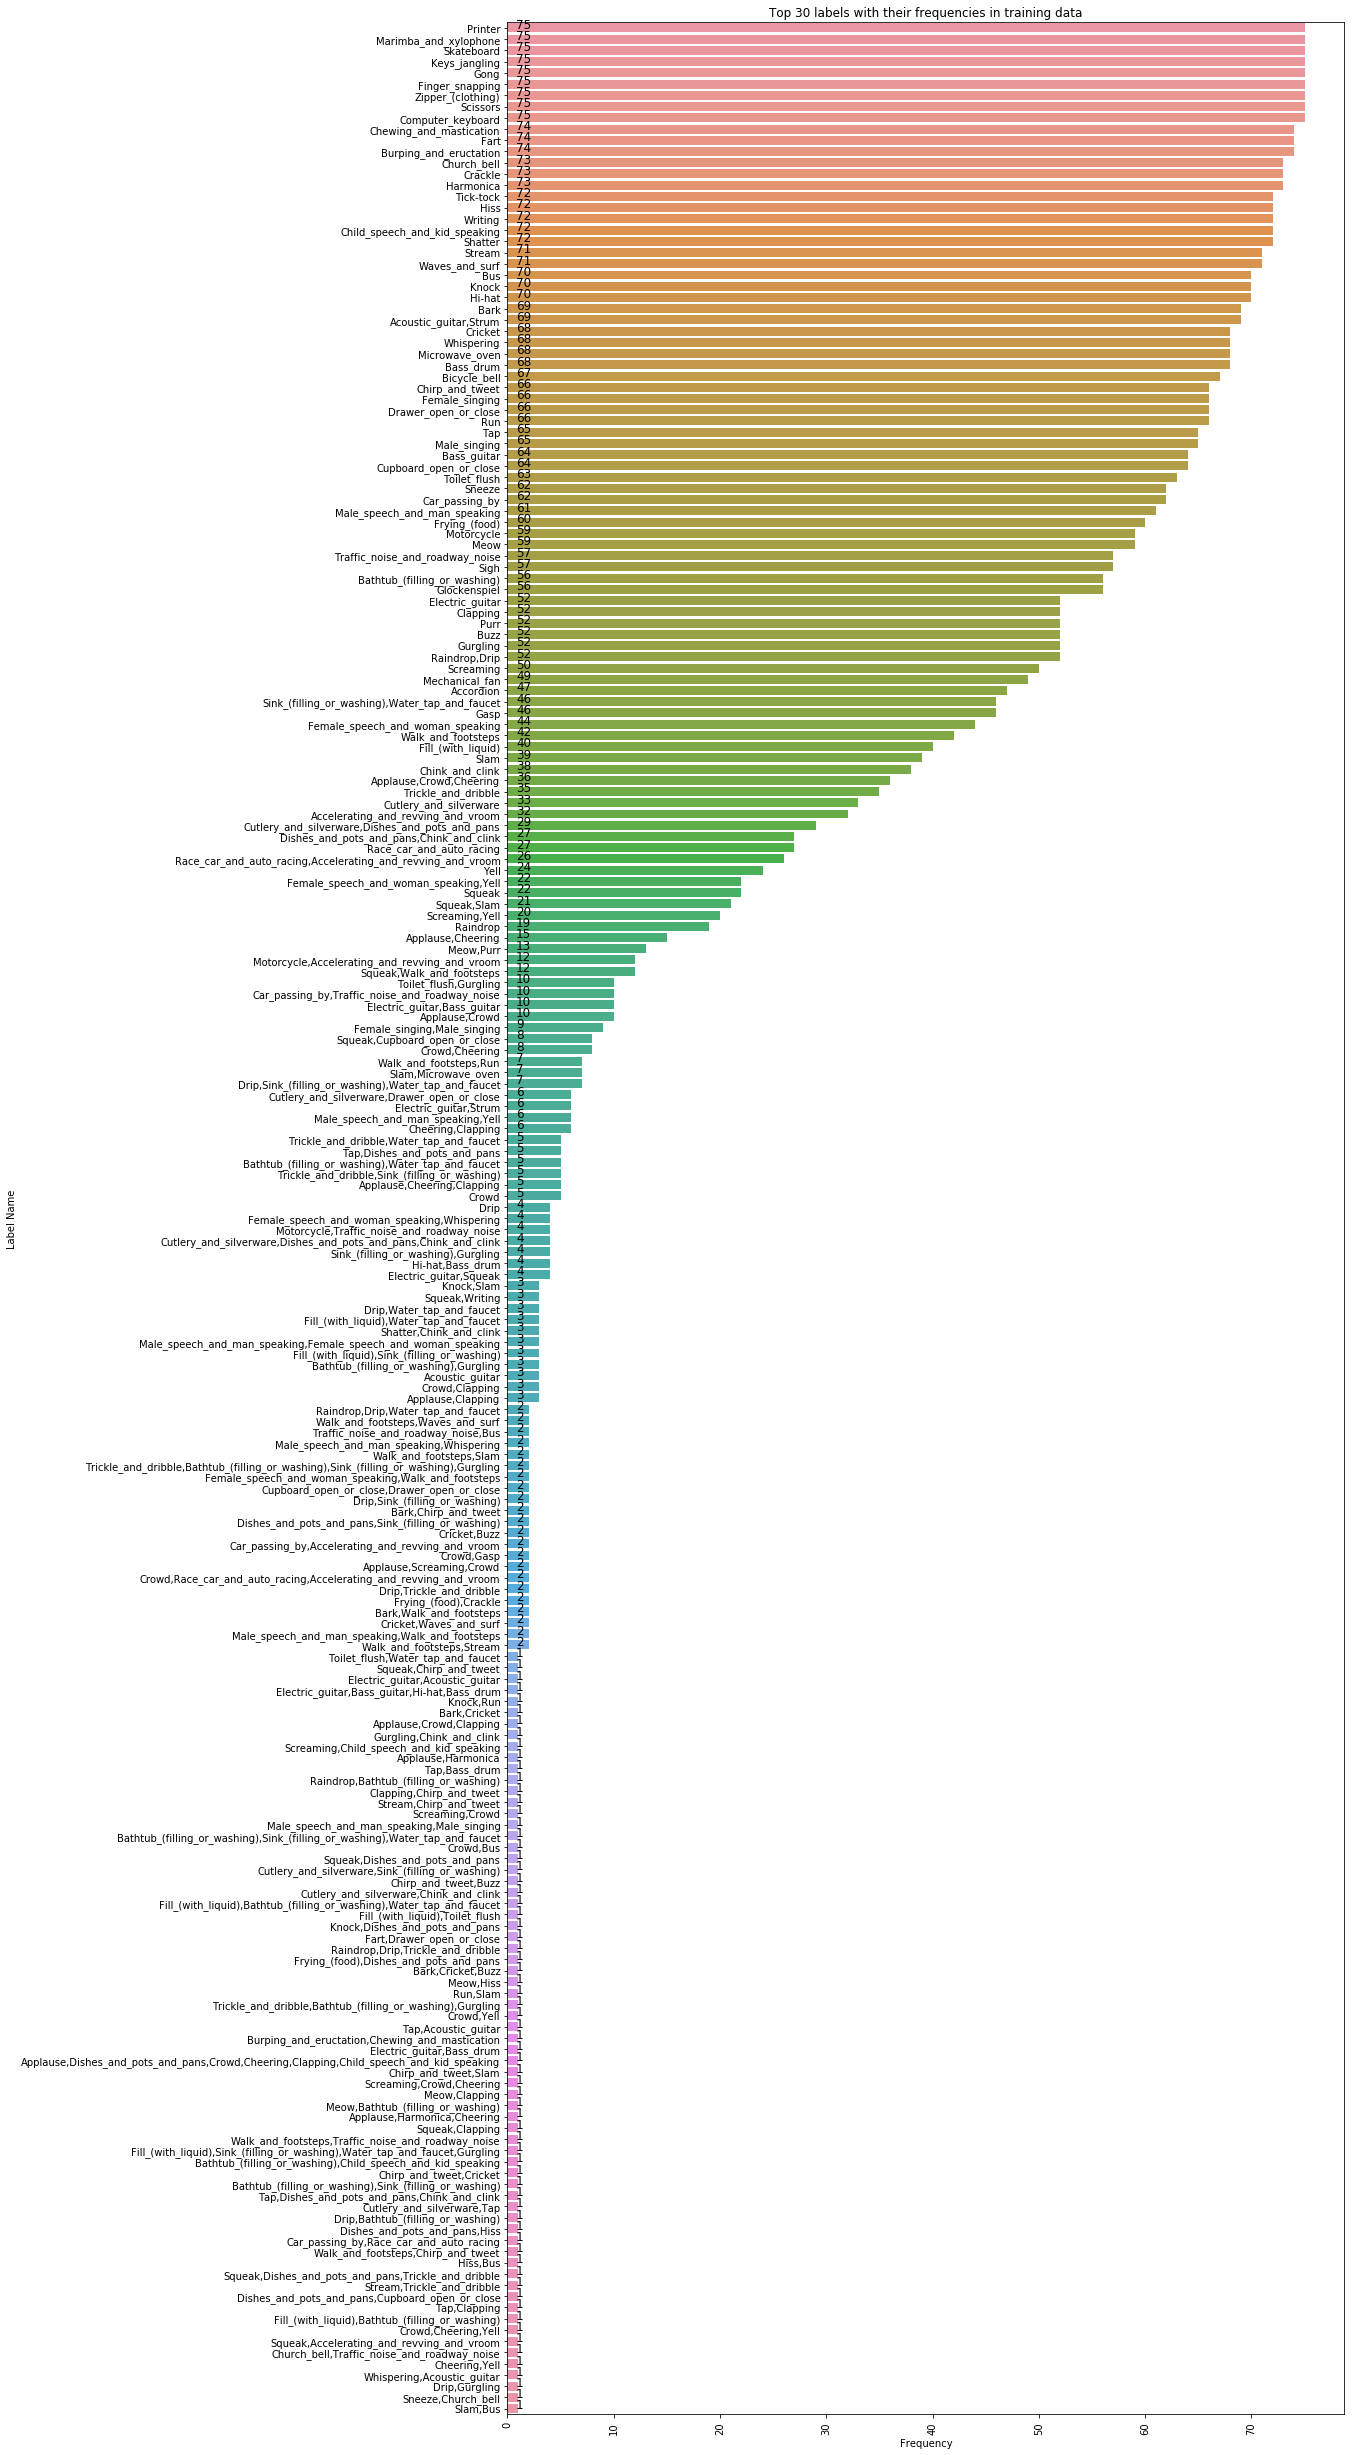

In [9]:
plt.figure(figsize=(15,44))
audio_type = train['labels'].value_counts()
sns.barplot(audio_type.values, audio_type.index)
for i, v in enumerate(audio_type.values):
    plt.text(0.8,i,v,color='k',fontsize=12)
plt.xticks(rotation='vertical')
plt.xlabel('Frequency')
plt.ylabel('Label Name')
plt.title("Top 30 labels with their frequencies in training data")
plt.show()

## Audio Length

In [10]:
train_new = train.sort_values('labels').reset_index()
train_new['nframes'] = train_new['fname'].apply(lambda f: wave.open('data/train_curated/' + f).getnframes())

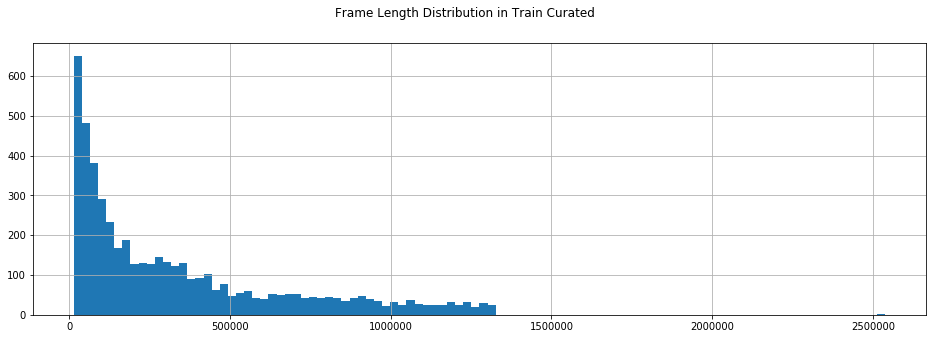

In [11]:
path = "data/train_curated/"
fig, axes = plt.subplots(figsize=(16,5))
train_new.nframes.hist(bins=100)
plt.suptitle('Frame Length Distribution in Train Curated', ha='center', fontsize='large');

There seems to be some outlier at ~2,500,000. Let's find out what it is.

In [12]:
train_new[train_new.nframes > 1500000]

index         fname  labels  nframes
4240   2316  77b925c2.wav  Stream  2538889

In [13]:
import IPython.display as ipd
ipd.Audio('data/train_curated/' + "77b925c2.wav")

This is labelled as "Stream" but is obviously not a stream, so let's remove it.

In [14]:
os.remove('data/train_curated/77b925c2.wav')

In [7]:
train[train['fname'] == '77b925c2.wav']

Empty DataFrame
Columns: [fname, labels]
Index: []

In [10]:
train = train.drop([2316])
train.to_csv('data/train_curated.csv', index=False)

## Validation Set

Our training data comes from two sources:
1. A curated set with mild imbalance
2. A noisy set with no imbalance

Our test set comes from the same source as the curated set. We don't know if the labels for the test set are balanced. With this is mind I think we should create our validation set based solely off the curated set. We'll try to use stratified k-folds on this curated training set.

In [94]:
from sklearn.preprocessing import MultiLabelBinarizer
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import numpy as np

train = pd.read_csv("data/train_curated.csv")
train_noisy = pd.read_csv("data/train_noisy.csv")
test = pd.read_csv("data/sample_submission.csv")


In [123]:
x = train['fname']
y = train['labels'].apply(lambda f: f.split(','))

In [135]:
# Because our dataset is multilabel, we first convert it into 
# a binary representation with a column for each category
transformed_y = MultiLabelBinarizer().fit_transform(y)
print(transformed_y.shape)

(4970, 80)


In [146]:
mskf = MultilabelStratifiedKFold(n_splits=5, random_state=4, shuffle=True)

print(len(x))
for train_index, val_index in mskf.split(x, transformed_y):
    
    current_train = transformed_y[train_index]
    current_val = transformed_y[val_index]
    
    print(current_val.shape)
    
    temp = current_val.sum(axis=0)
    print(temp)
    print()

4970
(1001, 80)
[15  9 15 15 15 15 15 15 13 15 15 11 15 16 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 10 15 12 10 12 15 15 15 15 15 15 15 15 15 15
 10 15 15 15 15 13 11 15 15 15 15 15 11 15 15 15 12 15 15 15 15 14 15 15
 10 15 15 15 15 15 15 15]

(997, 80)
[15  9 16 15 15 15 15 15 13 15 15 11 15 14 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 10 15 13 10 11 15 15 15 15 15 15 15 15 15 15
 10 15 15 15 15 13 11 15 15 15 15 15 11 15 15 15 13 15 15 15 15 14 15 15
 11 15 17 15 15 15 15 15]

(988, 80)
[15  9 15 15 15 15 15 15 14 15 15 11 15 14 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 10 15 13 10 11 15 15 15 15 15 15 15 15 15 15
  9 15 15 15 15 13 12 15 15 15 15 15 11 15 15 15 12 15 15 15 15 15 15 15
 11 15 15 15 15 15 15 15]

(992, 80)
[15 10 15 15 15 15 15 15 13 15 15 11 15 17 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 10 15 12  9 11 15 15 15 15 15 15 15 15 15 15
 10 15 15 15 15 13 11 15 15 15 15 15 12 15 15 15 13 15 15 15 15 15 15 